<h2>Derivative</h2>

In [1]:
import math

If you increase a variable <b>c</b> by a small amount <b>h</b>, how much the final expression <b>d1</b> varies

In [2]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 4.0001
slope: 0.9999999999976694


<h2>Value object</h2>

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(label={self.label}, data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # adding this node only after all the children are visited
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
    
    

In [4]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(label=, data=-2.0)

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L.data

-8.0

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, 
                 label="{ %s | data %.4f | grad %.4f}" %(
                     n.label, n.data, n.grad
                 ), 
                 shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

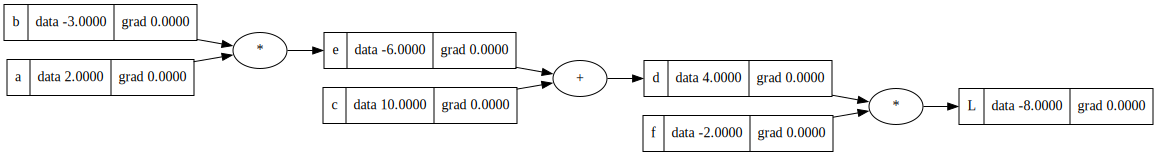

In [7]:
draw_dot(L)

<h2>Backpropagation - manual</h2>

In [8]:
# derivate of L w.r.t each node
L.grad = 1.0
d.grad = L.grad * f.data
f.grad = L.grad * d.data
e.grad = d.grad * 1.0 # chain rule
c.grad = d.grad * 1.0 # chain rule
a.grad = e.grad * b.data
b.grad = e.grad * a.data

In [9]:
# Nudge our input to increase L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e = a*b
d = e + c
L = d*f
L.data

-7.286496

In [10]:
def lol():
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)

lol()

-1.9999999999242843


<h2>Backpropagation - Neuron</h2>

In [11]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'

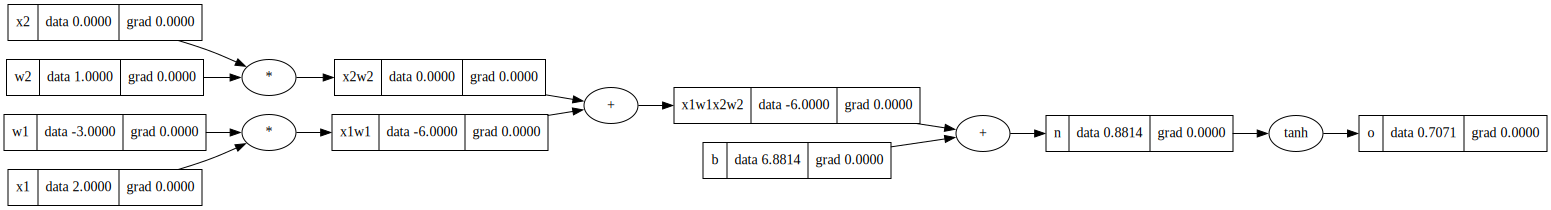

In [12]:
draw_dot(o)

In [13]:
o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

<h3>Backpropagation - for each node</h3>

In [14]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

<h3>Backpropagation - for whole expression</h3>

In [15]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # adding this node only after all the children are visited
build_topo(o)
topo

[Value(label=b, data=6.881373587019543),
 Value(label=w2, data=1.0),
 Value(label=x2, data=0.0),
 Value(label=x2w2, data=0.0),
 Value(label=w1, data=-3.0),
 Value(label=x1, data=2.0),
 Value(label=x1w1, data=-6.0),
 Value(label=x1w1x2w2, data=-6.0),
 Value(label=n, data=0.8813735870195432),
 Value(label=o, data=0.7071067811865476)]

In [16]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

In [17]:
o.backward()

<h5>Repeated nodes</h5>

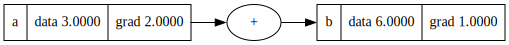

In [18]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

<h3>Backpropagation - breakdown of tanh</h3>

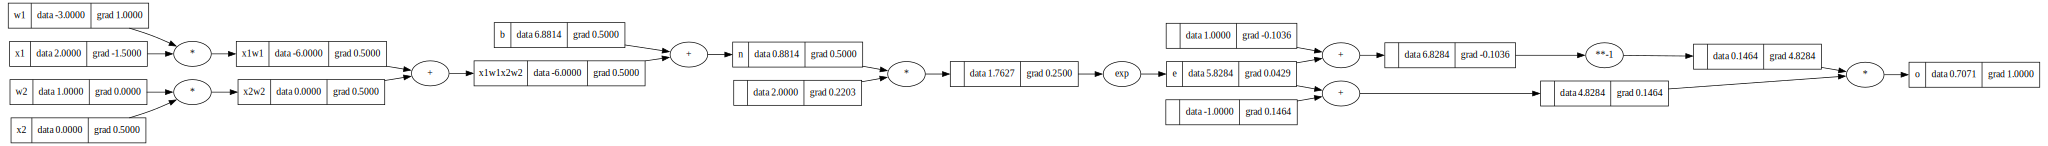

In [19]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'

o = (e - 1)/(e + 1); o.label='o'
o.backward()
draw_dot(o)

<h2>Backpropagation - using PyTorch</h2>

In [20]:
from torch import Tensor, tanh

In [21]:
x1 = Tensor([2.0]).double(); x1.requires_grad = True
x2 = Tensor([0.0]).double(); x2.requires_grad = True
w1 = Tensor([-3.0]).double(); w1.requires_grad = True
w2 = Tensor([1.0]).double(); w2.requires_grad = True
b = Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


<h2>Neural net - manual</h2>

In [4]:
import random

In [66]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]     
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(label=, data=0.39435815447007433)

In [11]:
n.parameters()

[Value(label=, data=0.5550008128057611),
 Value(label=, data=-0.4710991772250144),
 Value(label=, data=-0.6594774751689914),
 Value(label=, data=-0.9797805080232718),
 Value(label=, data=0.6902442727984603),
 Value(label=, data=-0.6547547353432439),
 Value(label=, data=0.7353344604485743),
 Value(label=, data=0.36168237162692995),
 Value(label=, data=-0.0016531947546658543),
 Value(label=, data=-0.03427936353307648),
 Value(label=, data=0.1365941772392898),
 Value(label=, data=-0.23210830287389794),
 Value(label=, data=0.6936877516995277),
 Value(label=, data=0.768190607326138),
 Value(label=, data=-0.12014706788735618),
 Value(label=, data=-0.8041118381821135),
 Value(label=, data=-0.17324435601434307),
 Value(label=, data=-0.6316962748124786),
 Value(label=, data=-0.3796171099334271),
 Value(label=, data=0.719104354730872),
 Value(label=, data=0.4864395973308102),
 Value(label=, data=-0.1460973866195996),
 Value(label=, data=-0.8690867867045482),
 Value(label=, data=0.588260360927604

In [67]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [85]:
for k in range(20):
    # forward pass to calculate loss
    ypreds = [n(x) for x in xs]
    loss = sum((ypred - y)**2 for ypred, y in zip(ypreds, ys))
    
    # backward pass to calculate gradients\
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update parameters to reduce loss
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.0027925866517083025
1 0.0027785448355924754
2 0.0027646389651780545
3 0.0027508671030554554
4 0.0027372273481671297
5 0.002723717834963261
6 0.0027103367325808266
7 0.0026970822440452987
8 0.002683952605493989
9 0.0026709460854209784
10 0.002658060983942146
11 0.002645295632080263
12 0.002632648391069331
13 0.002620117651677454
14 0.002607701833547937
15 0.0025953993845576956
16 0.0025832087801927785
17 0.002571128522940296
18 0.0025591571416962206
19 0.002547293191188754


In [83]:
n.layers[0].neurons[0].w[0].data

-0.4174226688399035

In [20]:
n.layers[0].neurons[0].w[0].grad

0.43783997104925076

In [56]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [86]:
ypreds

[Value(label=, data=0.9791649056047023),
 Value(label=, data=-0.9819553603616624),
 Value(label=, data=-0.9716698345596433),
 Value(label=, data=0.9686155334731918)]